This notebook is used to create strained configurations and vacancy migration NEB configurations for formin hard constraints matrix ${\bf A}_{\rm H}$ as well as MD configurations for ${\bf A}_{\rm S}$ matrix.

In [3]:
import sys
import numpy as np

import matplotlib.pyplot as plt

import numpy as np
sys.path.insert(0, "../LML_retrain/")
from LML_retrain import LMLPotential

from ase.build import bulk


from matscipy.dislocation import get_elastic_constants

In [4]:
LML_pot = LMLPotential("../potentials/milady_lml")
LML_calc = LML_pot.make_lammpslib_calc(use_default_linear=True)

In [5]:
alat, C11, C12, C44 = get_elastic_constants(calculator=LML_calc)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:30:30       -9.547996*       1.2985
FIRE:    1 16:30:30       -9.556932*       0.0908
FIRE:    2 16:30:30       -9.549601*       1.1537
FIRE:    3 16:30:30       -9.552517*       0.8983
FIRE:    4 16:30:30       -9.555910*       0.4405
FIRE:    5 16:30:30       -9.556894*       0.1229
FIRE:    6 16:30:30       -9.556904*       0.1159
FIRE:    7 16:30:30       -9.556920*       0.1023
FIRE:    8 16:30:30       -9.556939*       0.0829
FIRE:    9 16:30:30       -9.556958*       0.0588
FIRE:   10 16:30:30       -9.556971*       0.0313
FIRE:   11 16:30:30       -9.556977*       0.0022
FIRE:   12 16:30:30       -9.556973*       0.0271
FIRE:   13 16:30:30       -9.556973*       0.0267
FIRE:   14 16:30:30       -9.556973*       0.0260
FIRE:   15 16:30:30       -9.556973*       0.0248
FIRE:   16 16:30:30       -9.556974*       0.0234
FIRE:   17 16:30:30       -9.556974*       0.0215
FI

In [6]:
print(alat, C11, C12, C44)

3.1855100648148498 513.1383143516246 201.0126423807001 144.87459179400997


In [7]:
(C11 + 2*C12) / 3.0

305.0545330376749

In [8]:
(C11 - C12) / 2.0

156.06283598546224

In [9]:
def create_strained_configurations(alat=3.1855, symbol="W", max_strain=0.01, steps=17, size=5, ):

    # strain_mat: uniaxial when a=b, pure shear when a.b = 0
    def strain_mat(a, b): 
        return (np.outer(a, b)+np.outer(b, a)) / np.linalg.norm(a) / np.linalg.norm(b) / 2.0
    
    strain_types = {r"Hydrostatic" : np.diag([1, 1, 1]) / 3.,
                    r"Uniaxial [100]" : strain_mat([1, 0, 0] , [1, 0, 0]),
                    r"Uniaxial [111]" : strain_mat([1, 1, 1] , [1, 1, 1]),
                    r"Shear $[100],[010]$" : strain_mat([1, 0, 0] , [0, 1, 0]), 
                    r"Shear $[110],[001]$" : strain_mat([1, 1, 0], [0, 0, 1]),
                    r"Shear $[110],[1\bar{1}2]$" : strain_mat([1, 1, 0], [1, -1, 2])}
    
    
    bulk_atoms = bulk(symbol, a=alat, cubic=True)
    bulk_atoms *= size
    bulk_cell = bulk_atoms.cell.copy()[:]
    
    strained_configs = {}
    for strain_type_label, strain_type in strain_types.items():
        strained_configs[strain_type_label] = []
        for strain_value in np.linspace(-max_strain, +max_strain, steps):
            
            strain = np.eye(3) + strain_value * strain_type
            #print(strain)
            strained_atoms = bulk_atoms.copy()
            strained_atoms.set_cell(strain @ bulk_cell, scale_atoms=True)
            
            strained_atoms.info["strain_type"] = strain_type_label
            strained_atoms.info["strain_value"] = strain_value
            
            strained_configs[strain_type_label].append(strained_atoms)
    
    return strained_configs

# Creating and saving strained configurations for Hard constraints ${\bf A}_{\rm S}$

In [16]:
strained_configs = create_strained_configurations(alat=alat)

all_eos_configs = []
for label, config in strained_configs.items():
    for atoms in config:
        all_eos_configs.append(atoms)

labels = np.array([config.info["strain_type"] for config in all_eos_configs])



indexes = np.unique(labels, return_index=True)[1]
print([labels[index] for index in sorted(indexes)])

write("../data_files/eos_configurations.xyz", all_eos_configs)

['Hydrostatic', 'Uniaxial [100]', 'Uniaxial [111]', 'Shear $[100],[010]$', 'Shear $[110],[001]$', 'Shear $[110],[1\\bar{1}2]$']


In [14]:
# this is obtained from rotating the elastisity matrix (not included in this notebook)
# the values are used for testing the configurations
elastic_moduli_m = {r"Hydrostatic" : 305.05,
                    r"Uniaxial [100]" : 513.1383143516246,
                    r"Uniaxial [111]" : 499.46379367,
                    r"Shear $[100],[010]$" : 144.874, 
                    r"Shear $[110],[001]$" : 156.06283599,
                    r"Shear $[110],[1\bar{1}2]$" : 153.42973967}
    
    

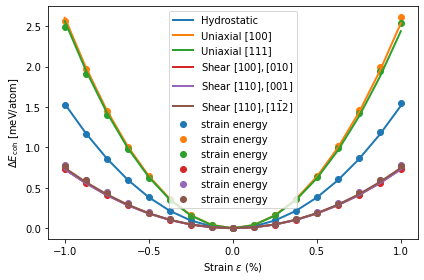

In [15]:
from ase import units
fig, ax = plt.subplots()

for strain_type, configs in strained_configs.items():
    # ax.set_title(strain_type)
    strains = []
    energies = []
    volumes = []
    for config in configs:
        strains.append(config.info["strain_value"])
        config.calc = LML_calc
        energies.append(config.get_potential_energy())
        volumes.append(config.get_volume())

    energies = np.array(energies) * 1.0e3 # show meV
    energies -= energies.min()
    
    strains = np.array(strains) * 1.0e2 # show %

    ax.plot(strains, energies / len(configs[0]), label=strain_type, lw=2.0)

    ax.set_xlabel(r'Strain $\epsilon$ (%)')
    ax.set_xticks(strains[::4])
    
    volumes = np.array(volumes)
    strain_energy = elastic_moduli_m[strain_type] * units.GPa * 0.5 * volumes * (0.01 * strains) ** 2 
    ax.scatter(strains, 1.0e3 * strain_energy / len(configs[0]), label="strain energy")
    
    ax.legend()
    
ax.set_ylabel(r"$\Delta E_{\rm coh}$ [meV/atom]")
ax.set_ylabel(r"$\Delta E_{\rm coh}$ [meV/atom]")
fig.tight_layout()


## Function to create MD configurations

In [18]:
from ase.io import write

from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.geometry.geometry import get_distances

def create_MD_configuration(alat=3.1855, symbol="W", size=5, vacancy=False,
                            temperature=1000, n_steps=200, timestep=1, calc=LML_calc):

    bulk_atoms = bulk(symbol, a=alat, cubic=True)
    bulk_atoms *= size
    
    if vacancy:
        # place vacancy near centre of cell
        D, D_len = get_distances(np.diag(bulk_atoms.cell) / 2,
                                 bulk_atoms.positions,
                                 bulk_atoms.cell, bulk_atoms.pbc)

        vac_index = D_len.argmin()
        vac_pos = bulk_atoms.positions[vac_index]

        del bulk_atoms[vac_index]
    
    bulk_atoms.calc = calc

    # Set the momenta corresponding to T=1000K
    MaxwellBoltzmannDistribution(bulk_atoms, temperature_K=2.0 * temperature)

    def printenergy(a=bulk_atoms):
        """Function to print the potential, kinetic and total energy"""
        epot = a.get_potential_energy() / len(a)
        ekin = a.get_kinetic_energy() / len(a)
        print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
              'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


    # dyn = Langevin(bulk_atoms, 5 * units.fs, friction=0.002, temperature_K=temperature)
    # We want to run MD with constant energy using the VelocityVerlet algorithm.
    dyn = VelocityVerlet(bulk_atoms, timestep * units.fs)  # 5 fs time step.
    dyn.attach(printenergy, interval=10)
    printenergy()
    dyn.run(n_steps)
    bulk_atoms.info["Temperature"] = (bulk_atoms.get_kinetic_energy() / (1.5 * units.kB)) / len(bulk_atoms)
    return bulk_atoms

# Create bulk and vacancy MD configurations for soft constraints $\bf{A}_{\rm S}$ 

In [20]:
temperatures = [300, 1000, 3000]

bulk_MD_configs = []
vac_MD_configs = []

for temperature in temperatures:
    
    bulk_MD_configs.append(create_MD_configuration(temperature=temperature, calc=LML2_calc))
    vac_MD_configs.append(create_MD_configuration(vacancy=True, temperature=temperature, calc=LML2_calc))

Energy per atom: Epot = -0.001eV  Ekin = 0.079eV (T=610K)  Etot = 0.078eV
Energy per atom: Epot = -0.001eV  Ekin = 0.079eV (T=610K)  Etot = 0.078eV
Energy per atom: Epot = 0.006eV  Ekin = 0.072eV (T=558K)  Etot = 0.078eV
Energy per atom: Epot = 0.023eV  Ekin = 0.055eV (T=424K)  Etot = 0.078eV
Energy per atom: Epot = 0.045eV  Ekin = 0.033eV (T=258K)  Etot = 0.078eV
Energy per atom: Epot = 0.062eV  Ekin = 0.016eV (T=124K)  Etot = 0.078eV
Energy per atom: Epot = 0.070eV  Ekin = 0.009eV (T= 66K)  Etot = 0.078eV
Energy per atom: Epot = 0.066eV  Ekin = 0.013eV (T= 97K)  Etot = 0.078eV
Energy per atom: Epot = 0.053eV  Ekin = 0.025eV (T=194K)  Etot = 0.078eV
Energy per atom: Epot = 0.038eV  Ekin = 0.040eV (T=311K)  Etot = 0.078eV
Energy per atom: Epot = 0.026eV  Ekin = 0.052eV (T=402K)  Etot = 0.078eV
Energy per atom: Epot = 0.022eV  Ekin = 0.057eV (T=437K)  Etot = 0.078eV
Energy per atom: Epot = 0.024eV  Ekin = 0.054eV (T=415K)  Etot = 0.078eV
Energy per atom: Epot = 0.032eV  Ekin = 0.046eV (

In [21]:
write("../data_files/bulk_MD_train.xyz", bulk_MD_configs)
bulk_MD_configs

[Atoms(symbols='W250', pbc=True, cell=[15.927500000000002, 15.927500000000002, 15.927500000000002], momenta=..., calculator=LAMMPSlib(...)),
 Atoms(symbols='W250', pbc=True, cell=[15.927500000000002, 15.927500000000002, 15.927500000000002], momenta=..., calculator=LAMMPSlib(...)),
 Atoms(symbols='W250', pbc=True, cell=[15.927500000000002, 15.927500000000002, 15.927500000000002], momenta=..., calculator=LAMMPSlib(...))]

In [22]:
write("../data_files/vac_MD_train.xyz", vac_MD_configs)
vac_MD_configs

[Atoms(symbols='W249', pbc=True, cell=[15.927500000000002, 15.927500000000002, 15.927500000000002], momenta=..., calculator=LAMMPSlib(...)),
 Atoms(symbols='W249', pbc=True, cell=[15.927500000000002, 15.927500000000002, 15.927500000000002], momenta=..., calculator=LAMMPSlib(...)),
 Atoms(symbols='W249', pbc=True, cell=[15.927500000000002, 15.927500000000002, 15.927500000000002], momenta=..., calculator=LAMMPSlib(...))]

# Creating testing MD configurations

In [23]:
test_bulk_MD = create_MD_configuration(temperature=1000, calc=LML2_calc)


Energy per atom: Epot = -0.001eV  Ekin = 0.280eV (T=2165K)  Etot = 0.279eV
Energy per atom: Epot = -0.001eV  Ekin = 0.280eV (T=2165K)  Etot = 0.279eV
Energy per atom: Epot = 0.023eV  Ekin = 0.256eV (T=1979K)  Etot = 0.279eV
Energy per atom: Epot = 0.085eV  Ekin = 0.194eV (T=1498K)  Etot = 0.279eV
Energy per atom: Epot = 0.161eV  Ekin = 0.118eV (T=916K)  Etot = 0.279eV
Energy per atom: Epot = 0.220eV  Ekin = 0.059eV (T=454K)  Etot = 0.279eV
Energy per atom: Epot = 0.245eV  Ekin = 0.034eV (T=266K)  Etot = 0.279eV
Energy per atom: Epot = 0.231eV  Ekin = 0.049eV (T=376K)  Etot = 0.279eV
Energy per atom: Epot = 0.190eV  Ekin = 0.089eV (T=690K)  Etot = 0.279eV
Energy per atom: Epot = 0.143eV  Ekin = 0.136eV (T=1055K)  Etot = 0.279eV
Energy per atom: Epot = 0.107eV  Ekin = 0.172eV (T=1331K)  Etot = 0.279eV
Energy per atom: Epot = 0.093eV  Ekin = 0.186eV (T=1439K)  Etot = 0.279eV
Energy per atom: Epot = 0.100eV  Ekin = 0.179eV (T=1383K)  Etot = 0.279eV
Energy per atom: Epot = 0.120eV  Ekin = 0

In [24]:
test_bulk_MD.write("../data_files/bulk_MD_test.xyz")

In [25]:
test_vac_MD = create_MD_configuration(vacancy=True, temperature=1000, calc=LML2_calc)

Energy per atom: Epot = 0.013eV  Ekin = 0.269eV (T=2080K)  Etot = 0.281eV
Energy per atom: Epot = 0.013eV  Ekin = 0.269eV (T=2080K)  Etot = 0.281eV
Energy per atom: Epot = 0.036eV  Ekin = 0.245eV (T=1899K)  Etot = 0.281eV
Energy per atom: Epot = 0.096eV  Ekin = 0.185eV (T=1432K)  Etot = 0.281eV
Energy per atom: Epot = 0.170eV  Ekin = 0.111eV (T=862K)  Etot = 0.281eV
Energy per atom: Epot = 0.229eV  Ekin = 0.052eV (T=404K)  Etot = 0.282eV
Energy per atom: Epot = 0.255eV  Ekin = 0.026eV (T=205K)  Etot = 0.282eV
Energy per atom: Epot = 0.243eV  Ekin = 0.039eV (T=299K)  Etot = 0.281eV
Energy per atom: Epot = 0.203eV  Ekin = 0.079eV (T=607K)  Etot = 0.281eV
Energy per atom: Epot = 0.154eV  Ekin = 0.128eV (T=988K)  Etot = 0.281eV
Energy per atom: Epot = 0.113eV  Ekin = 0.168eV (T=1302K)  Etot = 0.281eV
Energy per atom: Epot = 0.093eV  Ekin = 0.188eV (T=1457K)  Etot = 0.281eV
Energy per atom: Epot = 0.096eV  Ekin = 0.185eV (T=1434K)  Etot = 0.281eV
Energy per atom: Epot = 0.116eV  Ekin = 0.16

In [26]:
test_vac_MD.write("../data_files/vac_MD_test.xyz")

# Function to create vacancy migration NEB configurations

In [20]:
from ase.optimize import FIRE
from ase.neb import NEB
import matscipy.dislocation as sd
from ase.geometry.geometry import get_distances

def Vac_migration(calculator,
                  fmax_relaxation=1.0e-3,
                  fmax_neb=1.0e-2,
                  n_knots=11):

    alat, _, _, _ = sd.get_elastic_constants(calculator=calculator)

    W_bulk = bulk("W", a=alat, cubic="True")
    W_bulk *= 5

    W_bulk.calc = calculator
    opt = FIRE(W_bulk)
    opt.run(fmax=fmax_relaxation)

    # place vacancy near centre of cell
    D, D_len = get_distances(np.diag(W_bulk.cell) / 2,
                             W_bulk.positions,
                             W_bulk.cell, W_bulk.pbc)

    vac_index = D_len.argmin()
    vac_pos = W_bulk.positions[vac_index]
    ini_vac = W_bulk.copy()
    del ini_vac[vac_index]

    # identify two opposing nearest neighbours of the vacancy
    D, D_len = get_distances(vac_pos,
                             ini_vac.positions,
                             ini_vac.cell, ini_vac.pbc)
    D = D[0, :]
    D_len = D_len[0, :]

    nn_mask = np.abs(D_len - D_len.min()) < 1e-8
    i1 = nn_mask.nonzero()[0][0]
    i2 = ((D + D[i1])**2).sum(axis=1).argmin()

    print(f'vac_index={vac_index} i1={i1} i2={i2} '
          f'distance={ini_vac.get_distance(i1, i2, mic=True)}')

    fin_vac = ini_vac.copy()
    fin_vac.positions[i1] = vac_pos

    for atoms in ini_vac, fin_vac:
        atoms.calc = calculator
        opt = FIRE(atoms)
        opt.run(fmax=fmax_relaxation)



    np.allclose(ini_vac.get_potential_energy(), fin_vac.get_potential_energy())

    print(ini_vac.get_potential_energy(), fin_vac.get_potential_energy())

    vacancy_formation_energy = ini_vac.get_potential_energy() - W_bulk.get_potential_energy() * len(ini_vac) / len(W_bulk)

    print(f"Vacancy formation energy: {vacancy_formation_energy:.3f} eV")


    images = [ini_vac] + \
             [ini_vac.copy() for i in range(n_knots)] + \
             [fin_vac]


    for image in images:
        image.calc = calculator

    vac_NEB = NEB(images, allow_shared_calculator=True)
    vac_NEB.interpolate()
    opt = FIRE(vac_NEB)

    opt.run(fmax=fmax_neb)

    return vac_NEB, vacancy_formation_energy

In [49]:
vac_NEB, formation_en = Vac_migration(LML_calc)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 16:52:35        0.008204*       1.2985
FIRE:    1 16:52:35       -0.000732*       0.0908
FIRE:    2 16:52:35        0.006599*       1.1537
FIRE:    3 16:52:35        0.003682*       0.8983
FIRE:    4 16:52:35        0.000289*       0.4405
FIRE:    5 16:52:35       -0.000695*       0.1229
FIRE:    6 16:52:35       -0.000704*       0.1159
FIRE:    7 16:52:35       -0.000720*       0.1023
FIRE:    8 16:52:35       -0.000740*       0.0829
FIRE:    9 16:52:35       -0.000758*       0.0588
FIRE:   10 16:52:35       -0.000772*       0.0313
FIRE:   11 16:52:35       -0.000777*       0.0022
FIRE:   12 16:52:35       -0.000773*       0.0271
FIRE:   13 16:52:35       -0.000773*       0.0267
FIRE:   14 16:52:35       -0.000774*       0.0260
FIRE:   15 16:52:35       -0.000774*       0.0248
FIRE:   16 16:52:35       -0.000774*       0.0234
FIRE:   17 16:52:35       -0.000775*       0.0215
FI

In [54]:
from ase.neb import NEBTools

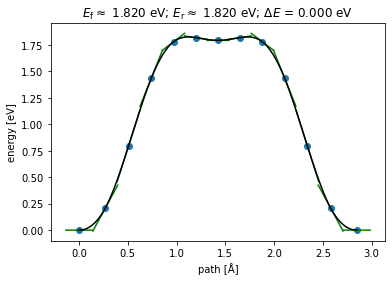

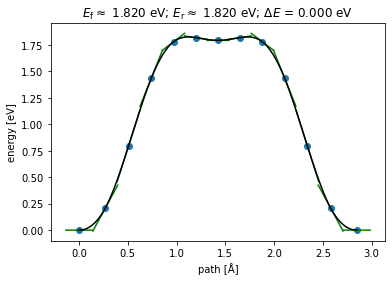

In [55]:
NEBTools(vac_NEB.images).plot_band()

In [56]:
write("../data_files/Vac_NEB_images.xyz", vac_NEB.images)